## Imports

In [164]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

sns.set(style="darkgrid")

## Data analysis

In [3]:
DATA_PATH = "data/winequality-red.csv"

base_data = pd.read_csv(DATA_PATH)
base_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
base_data.shape

(1599, 12)

In [5]:
base_data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [6]:
base_data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [7]:
base_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [114]:
len(base_data[base_data.duplicated()])

240

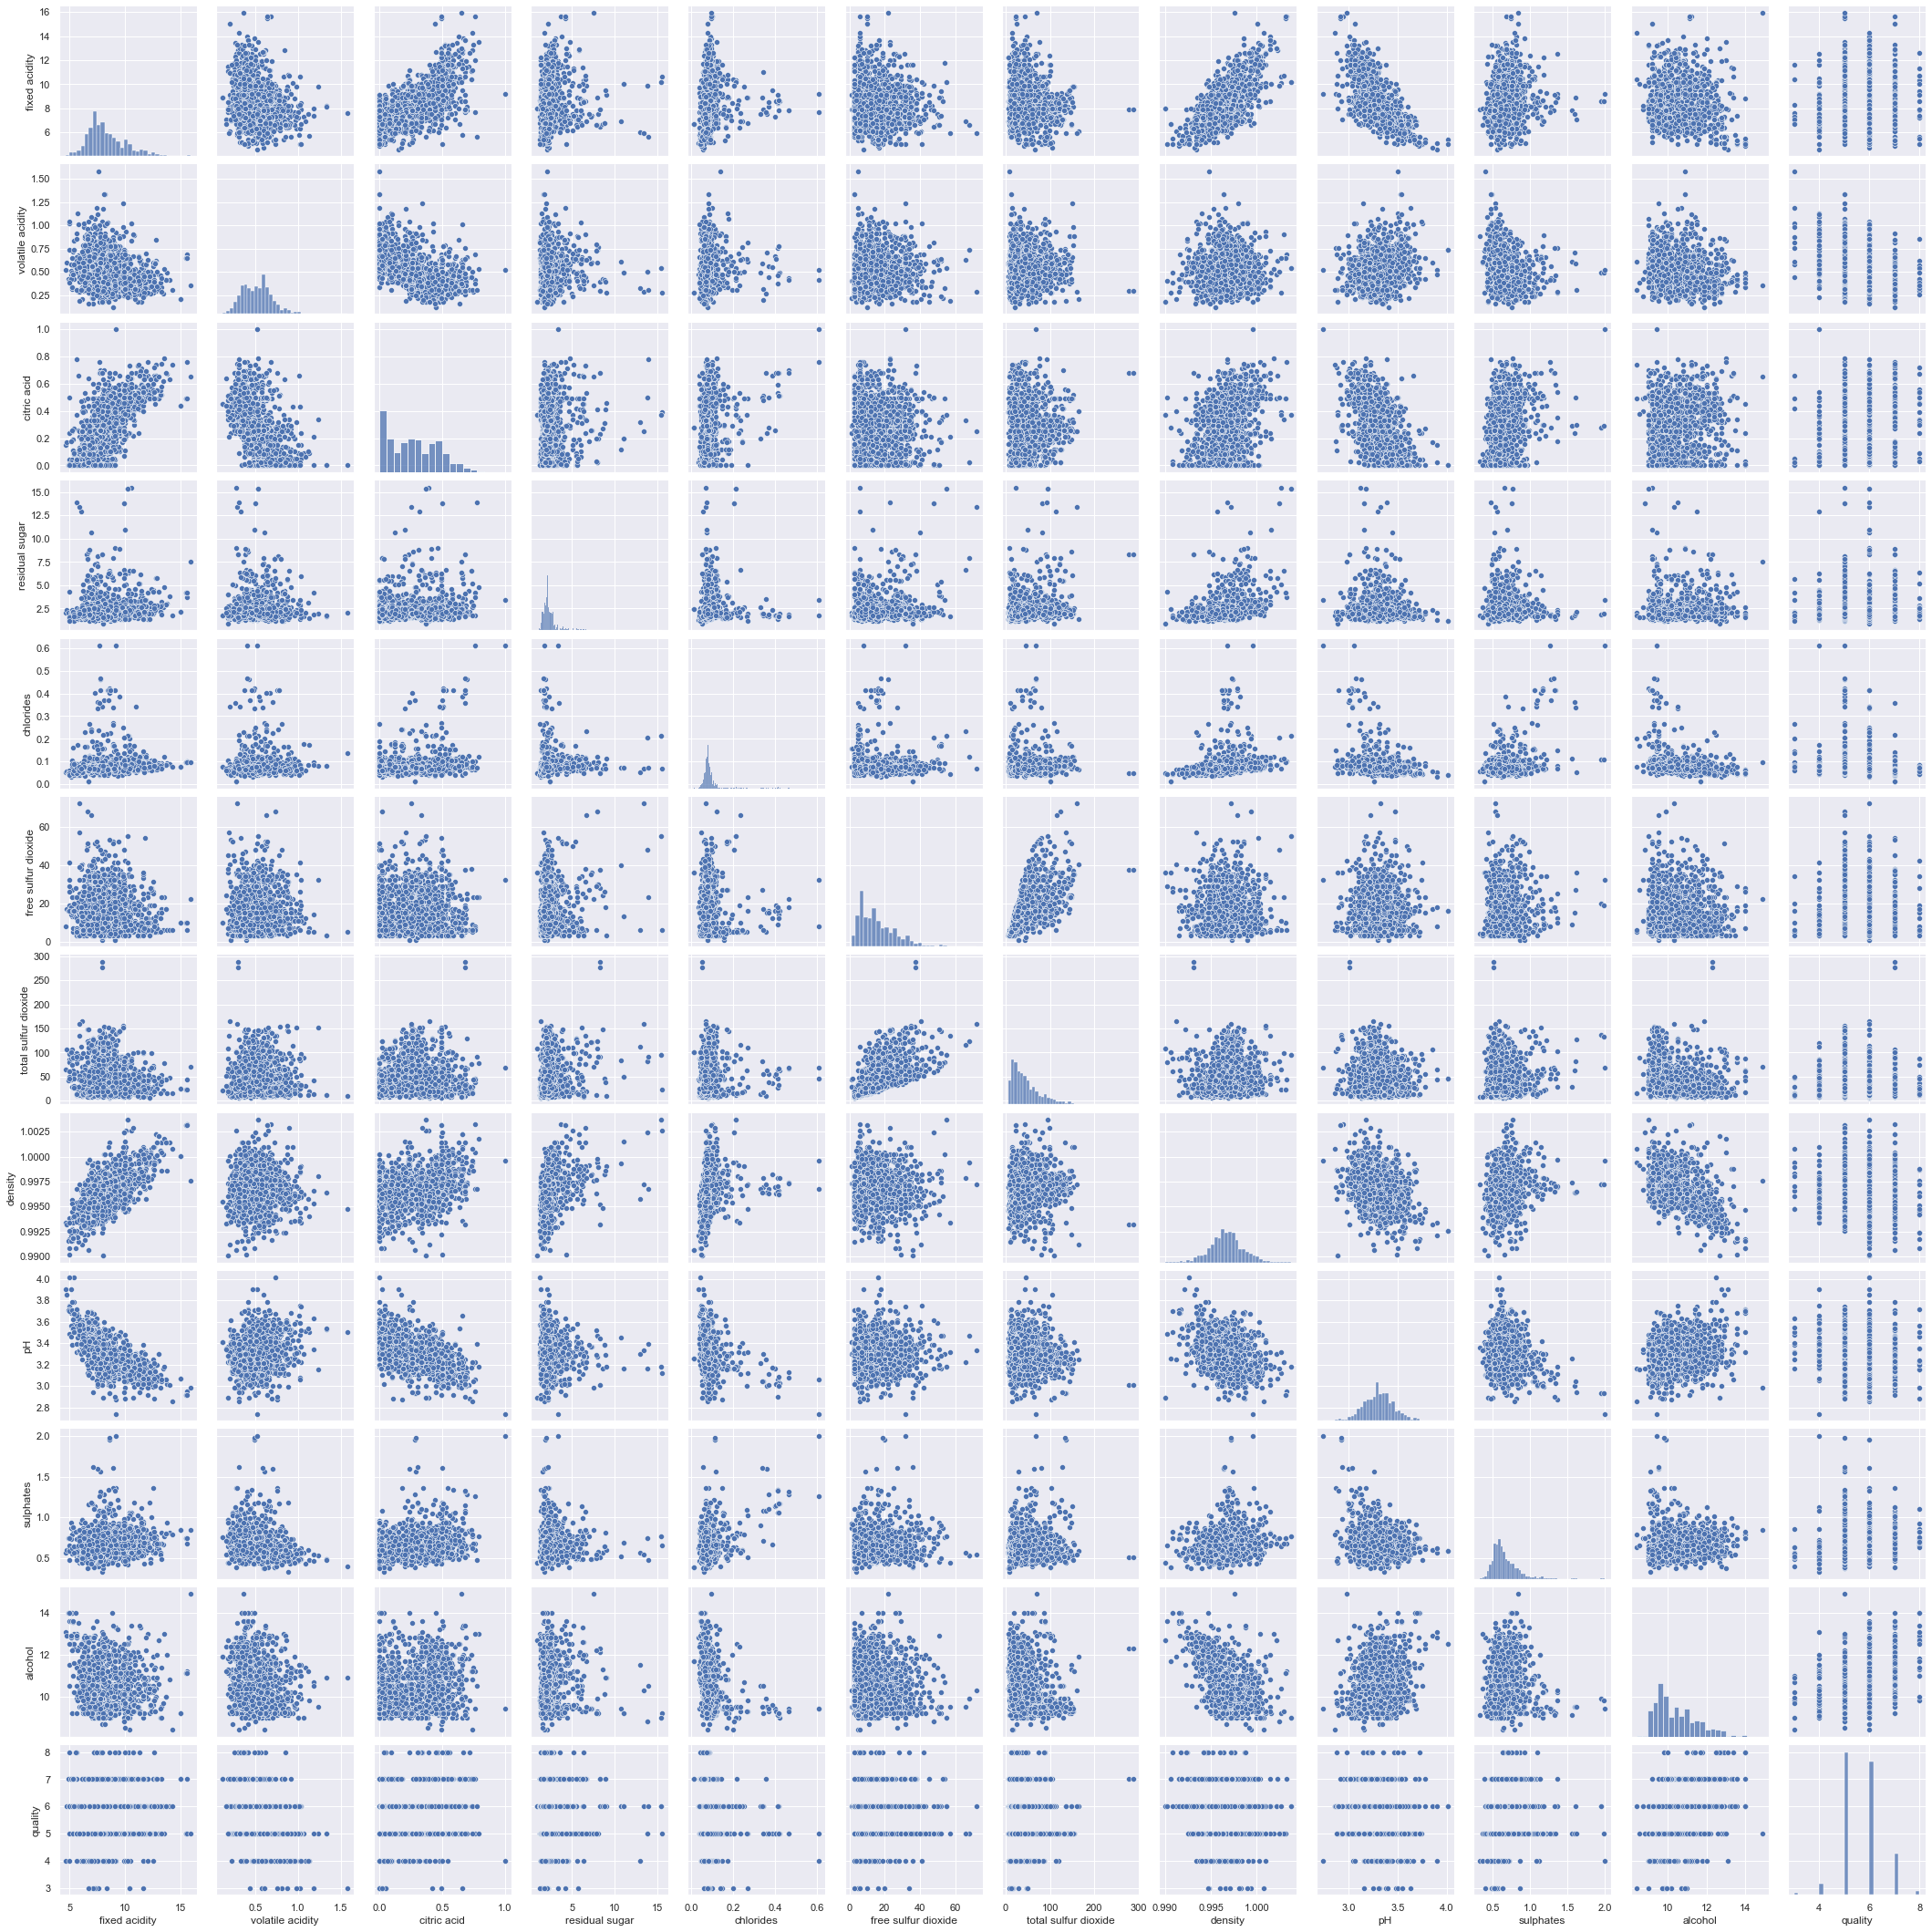

In [165]:
sns.pairplot(base_data)
plt.show()

In [9]:
base_data["quality"].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

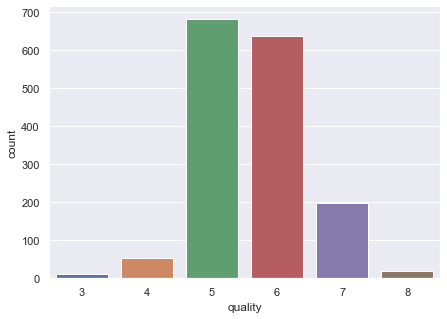

In [166]:
plt.figure(figsize=(7, 5))
sns.countplot(data=base_data, x="quality")
plt.show()

## VAE with pytorch

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Build data builder

In [12]:
def load_and_preprocess_data(data_path):
    # read csv
    df = pd.read_csv(data_path)
    df = df.values.reshape(-1, df.shape[1]).astype("float32")
    
    #train, test split
    X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
    
    # scale values
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    return X_train, X_test, scaler
    

In [13]:
class DataBuilder(Dataset):
    def __init__(self, path, train=True) -> None:
        self.X_train, self.X_test, self.scaler = load_and_preprocess_data(path)

        if train:
            self.x = torch.from_numpy(self.X_train)
            self.len = self.x.shape[0]
        else:
            self.x = torch.from_numpy(self.X_test)
            self.len = self.x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index]
    
    def __len__(self):
        return self.len

In [14]:
train_data = DataBuilder(DATA_PATH)
test_data = DataBuilder(DATA_PATH, train=False)

train_dataloader = DataLoader(train_data, batch_size=1024)
test_dataloader = DataLoader(test_data, batch_size=1024)

print("Train data shape", train_dataloader.dataset.x.shape)
print("Test data shape", test_dataloader.dataset.x.shape)

Train data shape torch.Size([1279, 12])
Test data shape torch.Size([320, 12])


In [15]:
train_dataloader.dataset.x

tensor([[ 0.2183,  0.8897,  0.1921,  ...,  0.4582,  1.1232,  0.4663],
        [-1.2902, -1.7888,  0.6528,  ..., -0.4012,  1.4083,  0.4663],
        [ 1.4948, -0.7843,  1.0110,  ...,  0.5155, -0.5874,  0.4663],
        ...,
        [-0.6520,  0.4991, -1.0875,  ..., -0.6877, -0.8725, -0.7735],
        [-0.2458, -1.8446,  0.3968,  ...,  0.8020,  1.4083,  1.7060],
        [-1.4642, -1.3424, -0.0638,  ..., -0.6877,  2.9288,  0.4663]])

## Build VAE model

In [16]:
class Autoencoder(nn.Module):
    def __init__(self, input_shape, num_features_1=50, num_features_2=12, latent_dim=3) -> None:
        # Call base class
        super().__init__()

        # Encoder
        self.encoder_linear1 = nn.Linear(in_features=input_shape, out_features=num_features_1)
        self.encoder_batch_norm1 = nn.BatchNorm1d(num_features=num_features_1)
        self.encoder_linear2 = nn.Linear(in_features=num_features_1, out_features=num_features_2)
        self.encoder_batch_norm2 = nn.BatchNorm1d(num_features=num_features_2)
        self.encoder_linear3 = nn.Linear(in_features=num_features_2, out_features=num_features_2)
        self.encoder_batch_norm3 = nn.BatchNorm1d(num_features=num_features_2)

        # Latent Vector
        self.latent_vector_linear1 = nn.Linear(in_features=num_features_2, out_features=latent_dim)
        self.latent_vector_batch_norm1 = nn.BatchNorm1d(num_features=latent_dim)
        self.latent_vector_linear2_1 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
        self.latent_vector_linear2_2 = nn.Linear(in_features=latent_dim, out_features=latent_dim)

        # Sampling Vector
        self.sampling_vector_linear1 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
        self.sampling_vector_batch_norm1 = nn.BatchNorm1d(num_features=latent_dim)
        self.sampling_vector_linear2 = nn.Linear(in_features=latent_dim, out_features=num_features_2)
        self.sampling_vector_batch_norm2 = nn.BatchNorm1d(num_features=num_features_2)

        # Decoder
        self.decoder_linear1 = nn.Linear(in_features=num_features_2, out_features=num_features_2)
        self.decoder_batch_norm1 = nn.BatchNorm1d(num_features=num_features_2)
        self.decoder_linear2 = nn.Linear(in_features=num_features_2, out_features=num_features_1)
        self.decoder_batch_norm2 = nn.BatchNorm1d(num_features=num_features_1)
        self.decoder_linear3 = nn.Linear(in_features=num_features_1, out_features=input_shape)
        self.decoder_batch_norm3 = nn.BatchNorm1d(num_features=input_shape)

        self.relu = nn.ReLU()

    def encode(self, x):
        linear1 = self.relu(self.encoder_batch_norm1(self.encoder_linear1(x)))
        linear2 = self.relu(self.encoder_batch_norm2(self.encoder_linear2(linear1)))
        linear3 = self.relu(self.encoder_batch_norm3(self.encoder_linear3(linear2)))

        latent1 = F.relu(self.latent_vector_batch_norm1(self.latent_vector_linear1(linear3)))

        latent2_1 = self.latent_vector_linear2_1(latent1)
        latent2_2 = self.latent_vector_linear2_2(latent1)

        return latent2_1, latent2_2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        sampling1 = self.relu(self.sampling_vector_batch_norm1(self.sampling_vector_linear1(z)))
        sampling2 = self.relu(self.sampling_vector_batch_norm2(self.sampling_vector_linear2(sampling1)))

        decoder1 = self.relu(self.decoder_batch_norm1(self.decoder_linear1(sampling2)))
        decoder2 = self.relu(self.decoder_batch_norm2(self.decoder_linear2(decoder1)))
        decoder3 = self.decoder_batch_norm3(self.decoder_linear3(decoder2))

        return decoder3

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [17]:
class CustomLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

## Train the model

In [18]:
model = Autoencoder(input_shape=train_dataloader.dataset.x.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = CustomLoss()

In [19]:
EPOCHS = 1500
LOG_INTERVAL = 50

train_losses = list()

In [20]:
def train_test(epoch, data_loader, mode):
    model.train()
    train_loss = 0

    for _, data in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    if epoch % 100 == 0:
        print("====> Epoch: {} Average {} loss: {:.4f}".format(
        epoch, mode, train_loss / len(data_loader.dataset)))
        train_losses.append(train_loss / len(data_loader.dataset))

In [21]:
for epoch in range(1, EPOCHS + 1):
    train_test(epoch=epoch, data_loader=train_dataloader, mode="training")
    train_test(epoch=epoch, data_loader=test_dataloader, mode="test")

====> Epoch: 100 Average training loss: 12.2864
====> Epoch: 100 Average test loss: 11.9706
====> Epoch: 200 Average training loss: 10.0028
====> Epoch: 200 Average test loss: 9.8019
====> Epoch: 300 Average training loss: 8.4304
====> Epoch: 300 Average test loss: 8.4737
====> Epoch: 400 Average training loss: 7.8357
====> Epoch: 400 Average test loss: 7.8447
====> Epoch: 500 Average training loss: 7.5862
====> Epoch: 500 Average test loss: 7.3747
====> Epoch: 600 Average training loss: 7.4799
====> Epoch: 600 Average test loss: 7.2882
====> Epoch: 700 Average training loss: 7.3436
====> Epoch: 700 Average test loss: 7.1938
====> Epoch: 800 Average training loss: 7.2921
====> Epoch: 800 Average test loss: 7.1530
====> Epoch: 900 Average training loss: 7.2467
====> Epoch: 900 Average test loss: 7.2637
====> Epoch: 1000 Average training loss: 7.2212
====> Epoch: 1000 Average test loss: 7.1209
====> Epoch: 1100 Average training loss: 7.1445
====> Epoch: 1100 Average test loss: 7.0401
===

## Fake vs. Real Data

In [22]:
with torch.no_grad():
    for _, data in enumerate(test_dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

In [23]:
scaler = train_dataloader.dataset.scaler

reconstruction_df = pd.DataFrame(scaler.inverse_transform(recon_batch[0].cpu().numpy().reshape(1, -1)), columns=base_data.columns)
real_df = pd.DataFrame(scaler.inverse_transform(test_dataloader.dataset.x[0].cpu().numpy().reshape(1, -1)), columns=base_data.columns)

In [24]:
fake_vs_real_df = pd.concat([real_df, reconstruction_df])
fake_vs_real_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.700000,0.560000,0.080000,2.50000,0.114000,14.000000,46.000000,0.997100,3.24000,0.660000,9.600000,6.000000
0,7.388899,0.552957,0.126394,2.07423,0.078326,13.160822,32.914043,0.996381,3.37127,0.599185,9.915656,5.611108


In [25]:
sigma = torch.exp(logvar / 2)

In [26]:
mu.mean(axis=0), sigma.mean(axis=0)

(tensor([ 0.0043, -0.0004, -0.0023]), tensor([0.2840, 0.9996, 0.3325]))

## Create Fake Data

In [44]:
number_of_samples = 1500
q_normal = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z_samples = q_normal.rsample(sample_shape=torch.Size([number_of_samples]))

In [45]:
z_samples.shape

torch.Size([1500, 3])

In [46]:
z_samples[:5]

tensor([[-0.0427,  0.3932,  0.0647],
        [ 0.3005,  0.4981, -0.0640],
        [-0.0104,  0.9631,  0.0882],
        [ 0.9288,  1.3345,  0.3915],
        [-0.0260,  1.0427, -0.1446]])

In [47]:
with torch.no_grad():
    pred = model.decode(z_samples).cpu().numpy()

In [48]:
pred[1]

array([ 1.0155166 , -0.5389206 ,  0.8201765 , -0.05947691,  0.1531483 ,
        0.35889658,  0.38032353,  0.9158493 , -0.58496416,  0.03568742,
       -0.56091183, -0.62619376], dtype=float32)

In [49]:
fake_data = scaler.inverse_transform(pred)
fake_data.shape

(1500, 12)

In [50]:
df_fake = pd.DataFrame(fake_data, columns=base_data.columns)
df_fake["quality"] = np.round(df_fake["quality"]).astype(int)
df_fake.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.756447,0.480736,0.222464,2.012535,0.082267,12.783434,33.562019,0.996664,3.341028,0.634269,9.885145,6
1,10.138218,0.421068,0.422540,2.394903,0.089114,19.827639,58.146549,0.998473,3.217808,0.655908,9.816655,5
2,8.053667,0.458701,0.276471,2.063913,0.077352,10.081297,34.284248,0.996630,3.307694,0.613281,10.032077,6
3,13.911535,0.407272,0.992186,4.656965,0.359577,13.305574,35.396729,1.000823,3.067603,0.918560,11.886507,5
4,7.741753,0.558340,0.162071,2.119028,0.074561,12.363951,43.443985,0.996821,3.322288,0.603673,9.751956,5


In [51]:
base_data.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1353,7.6,0.645,0.03,1.9,0.086,14.0,57.0,0.99690,3.37,0.46,10.3,5
1431,7.6,0.430,0.31,2.1,0.069,13.0,74.0,0.99580,3.26,0.54,9.9,6
515,8.5,0.655,0.49,6.1,0.122,34.0,151.0,1.00100,3.31,1.14,9.3,5
265,11.8,0.260,0.52,1.8,0.071,6.0,10.0,0.99680,3.20,0.72,10.2,7
1090,10.0,0.260,0.54,1.9,0.083,42.0,74.0,0.99451,2.98,0.63,11.8,8
1057,7.6,0.420,0.25,3.9,0.104,28.0,90.0,0.99784,3.15,0.57,9.1,5
383,8.3,0.260,0.42,2.0,0.080,11.0,27.0,0.99740,3.21,0.80,9.4,6
934,6.6,0.610,0.01,1.9,0.080,8.0,25.0,0.99746,3.69,0.73,10.5,5
1538,6.2,0.640,0.09,2.5,0.081,15.0,26.0,0.99538,3.57,0.63,12.0,5
1294,8.2,0.635,0.10,2.1,0.073,25.0,60.0,0.99638,3.29,0.75,10.9,6


## Compare real data with fake data

In [143]:
def plot_group_bar_plot(plot_data, title):
    fig_dims = (20, 8)
    fig, ax = plt.subplots(figsize=fig_dims)
    ax.set(ylim=(0, 40))

    group_plot = sns.barplot(data=plot_data, ax=ax, ci=None)
    group_plot.bar_label(group_plot.containers[0])
    group_plot.set_title(title)
    plt.show()

In [140]:
group_base = base_data.groupby("quality").mean()
group_fake = df_fake.groupby("quality").mean()

### Mean over all quality

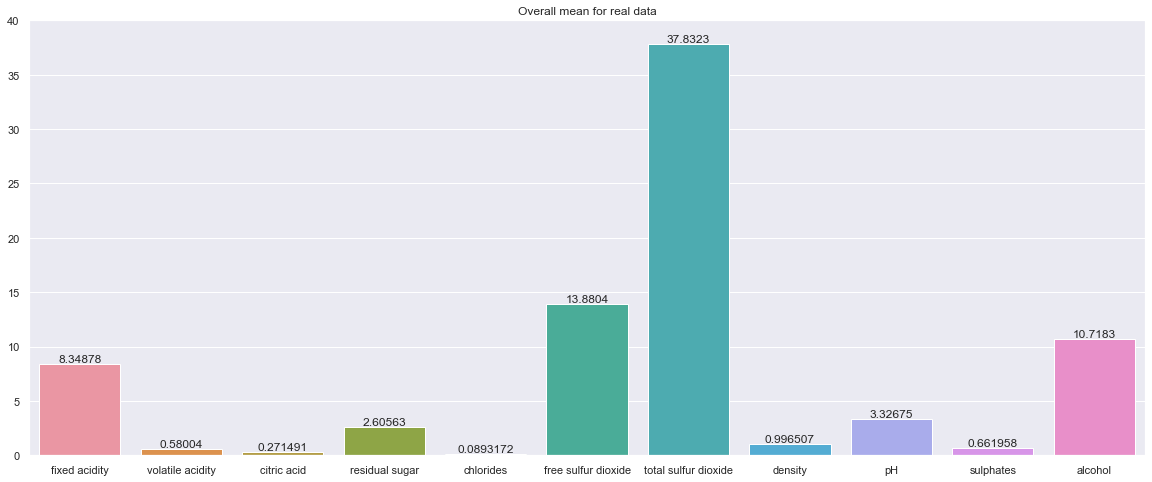

In [167]:
plot_group_bar_plot(group_base, "Overall mean for real data")

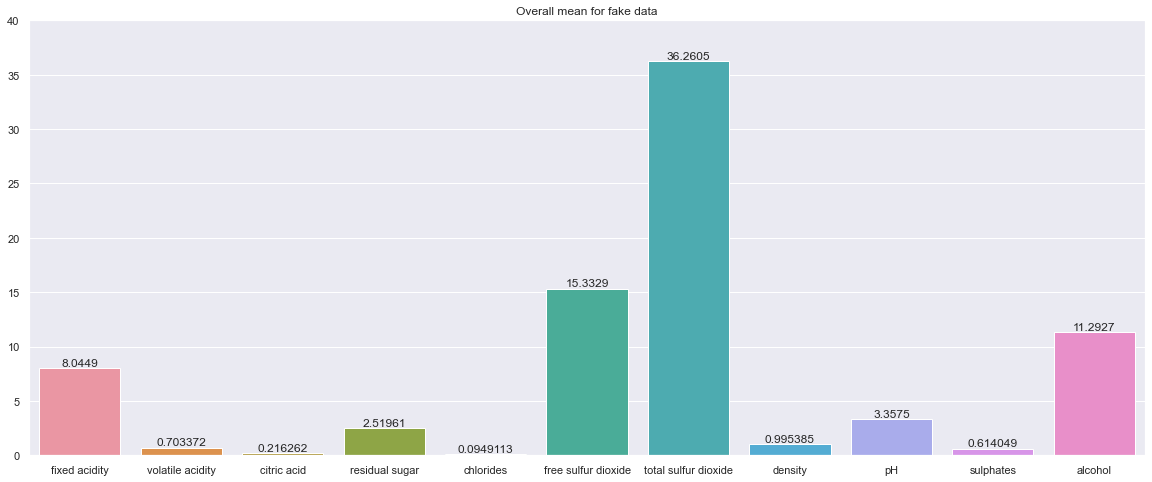

In [168]:
plot_group_bar_plot(group_fake, "Overall mean for fake data")

### Mean per quality

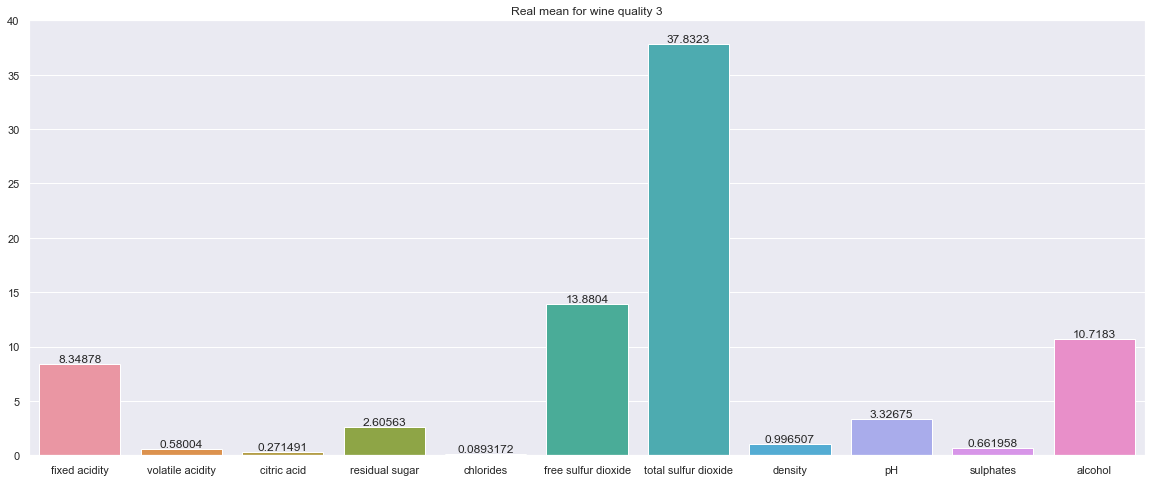

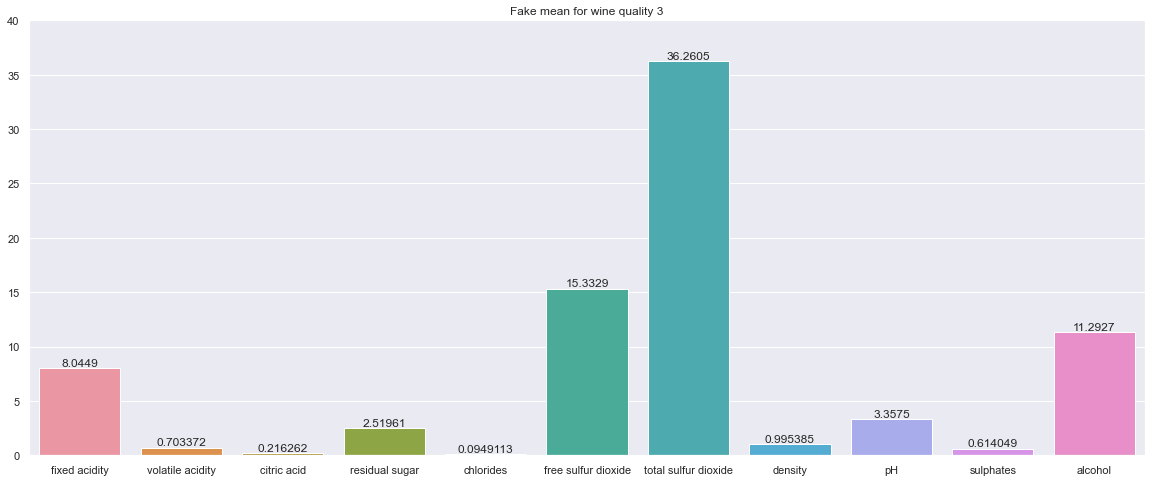

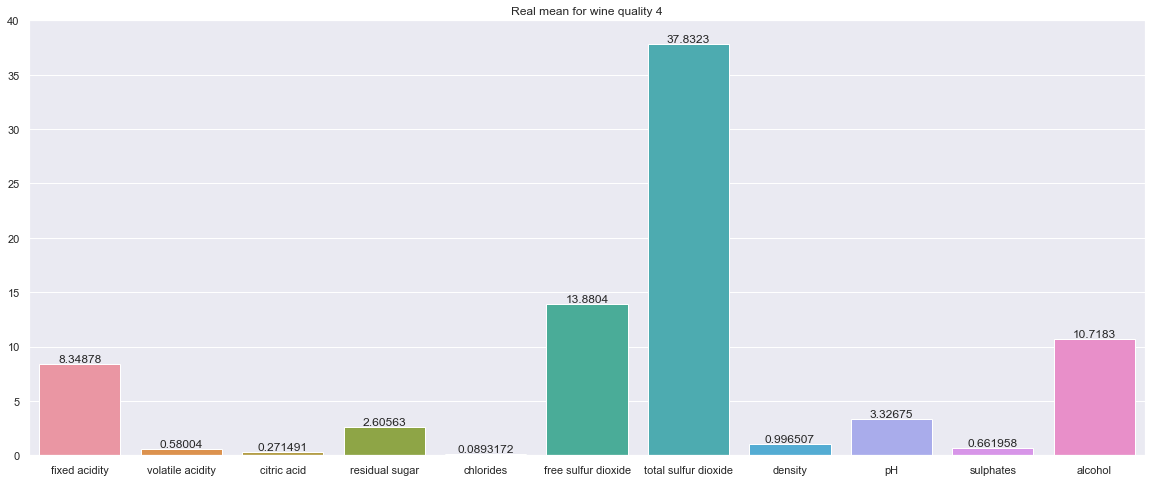

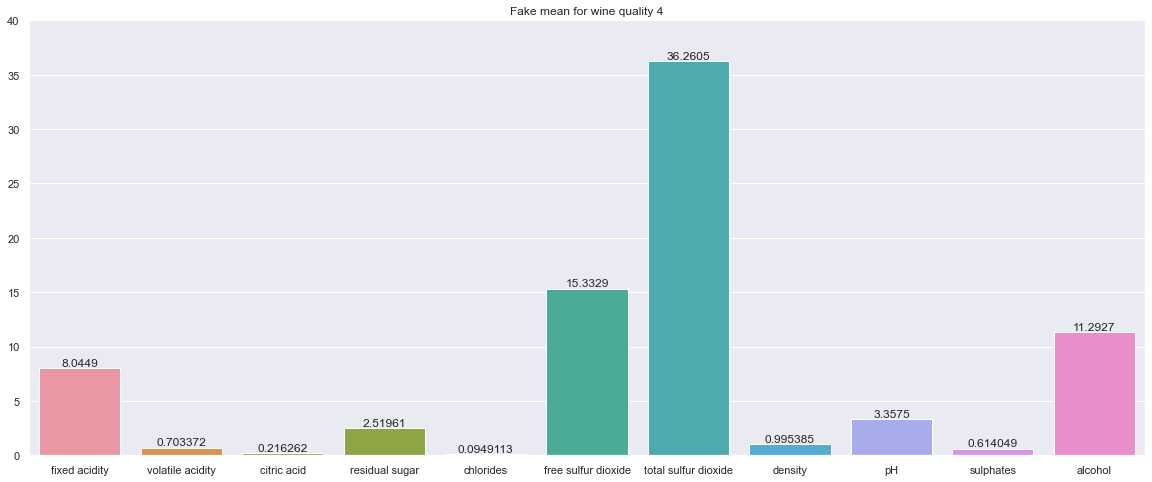

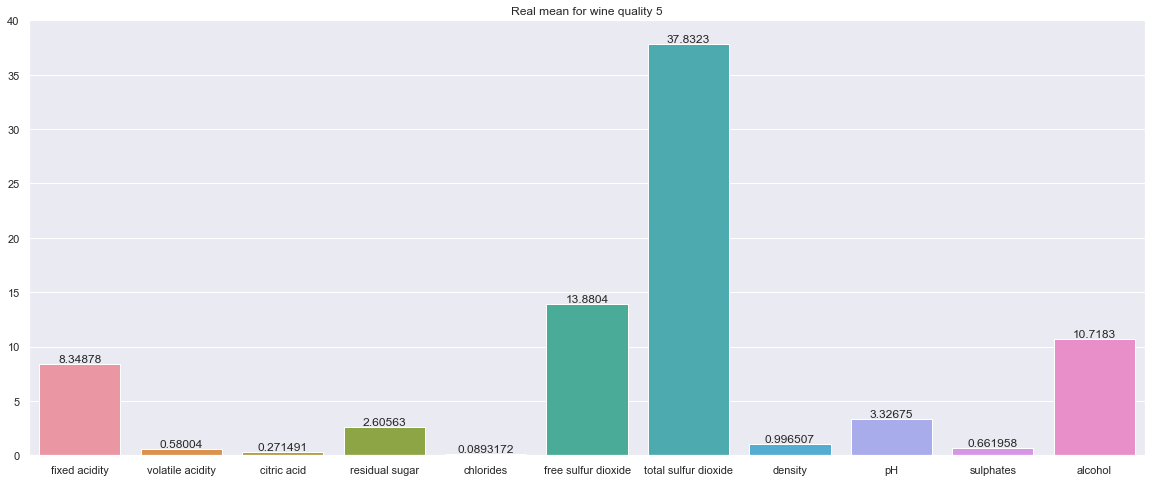

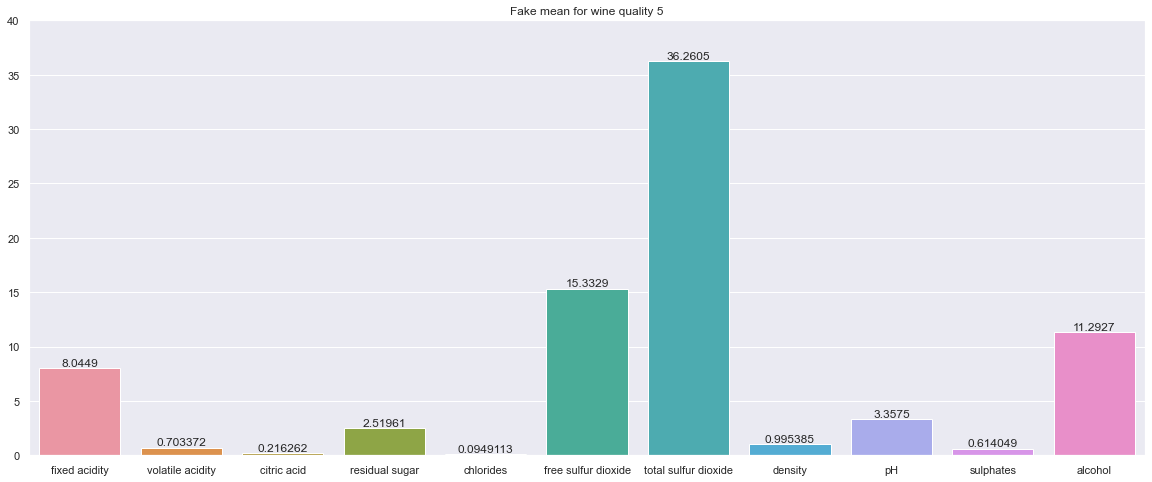

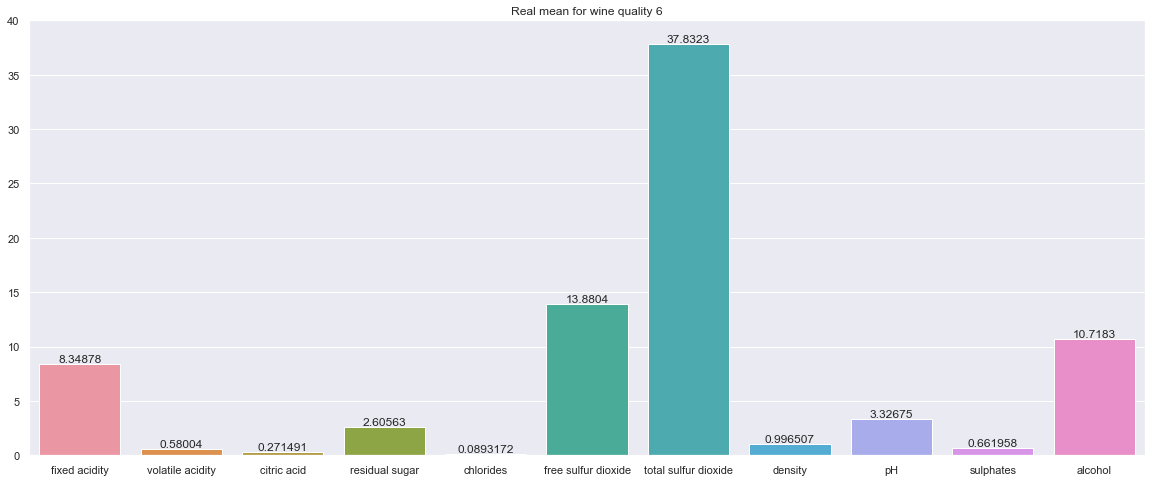

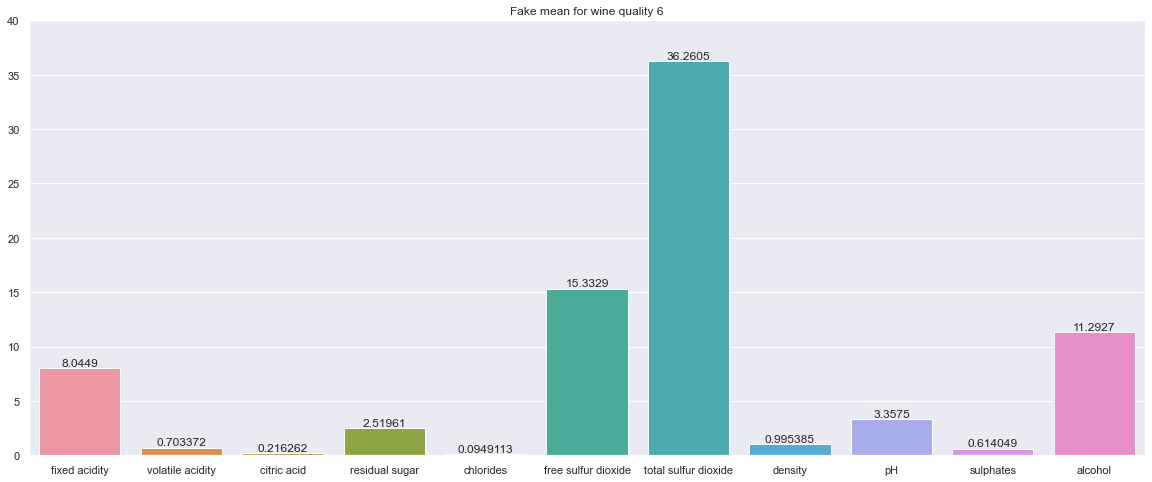

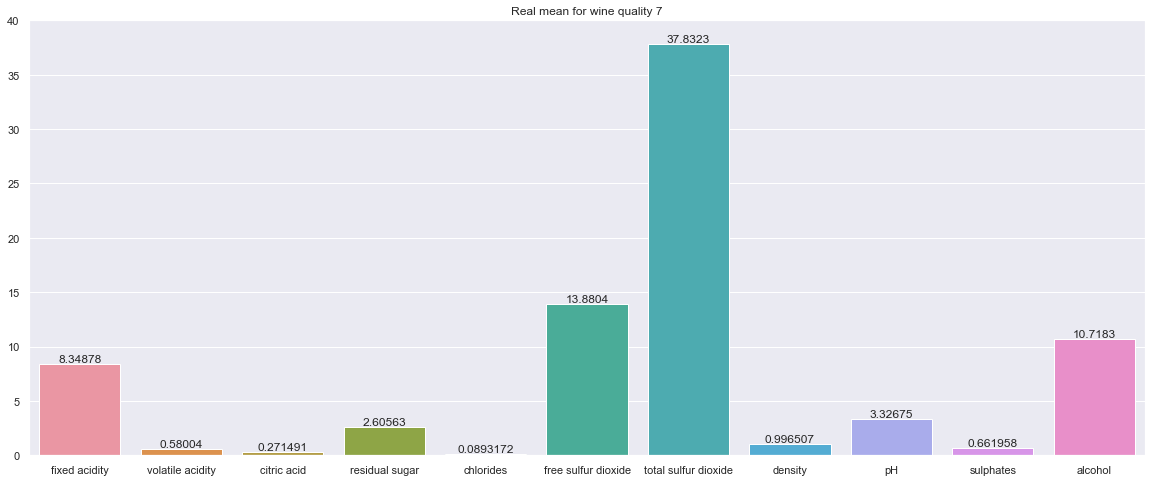

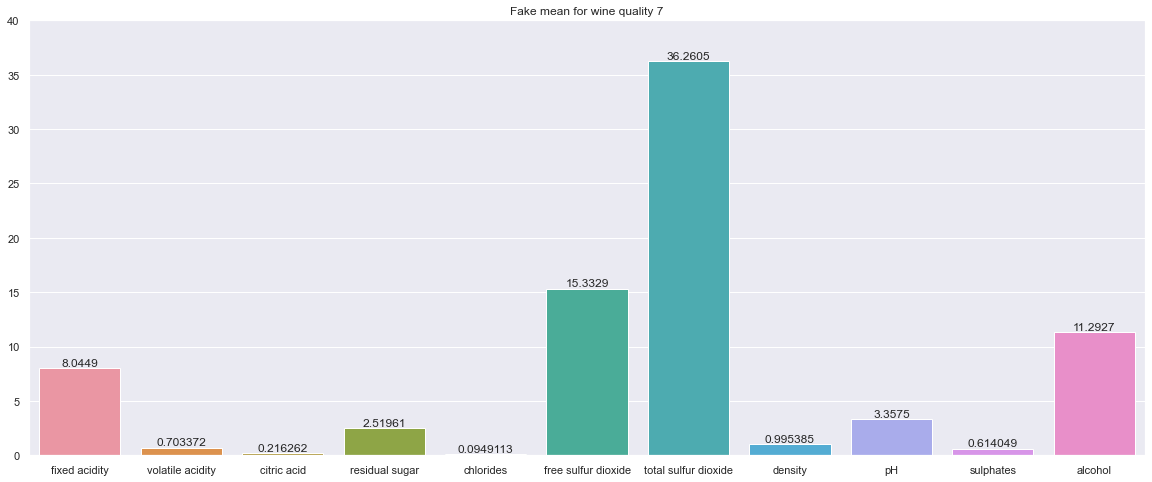

In [169]:
for q in range(3, 8):
    plot_group_bar_plot(group_base, f"Real mean for wine quality {q}")
    plot_group_bar_plot(group_fake, f"Fake mean for wine quality {q}")

### Compare distribution

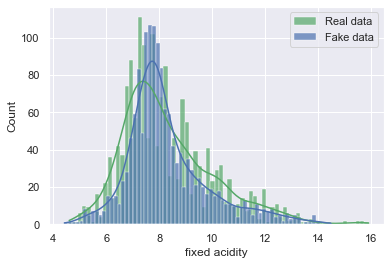

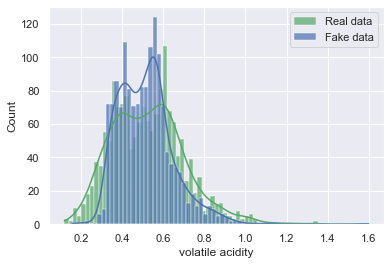

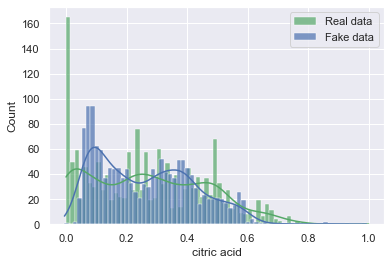

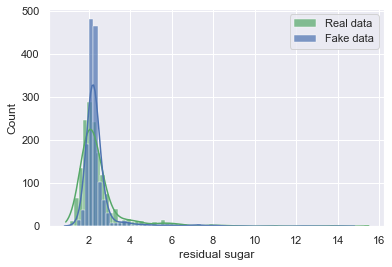

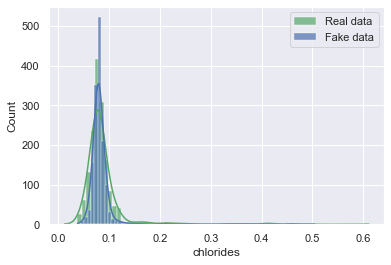

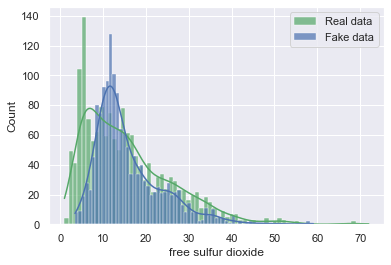

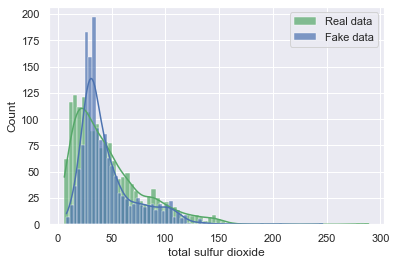

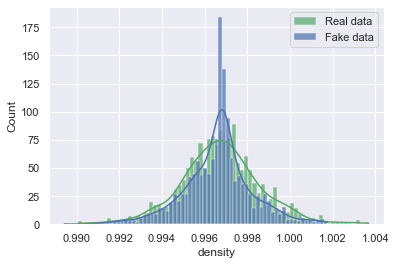

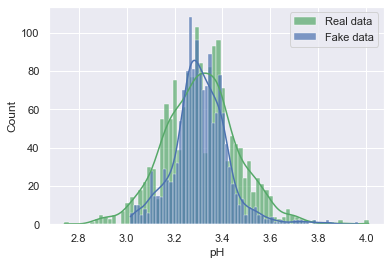

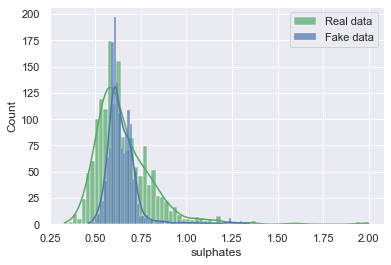

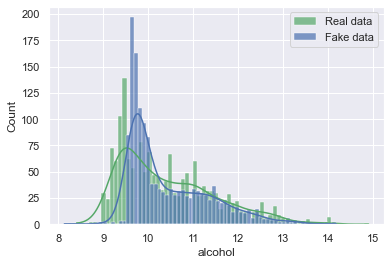

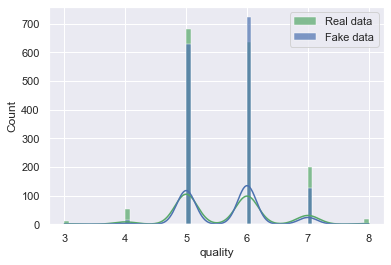

In [187]:
for column in base_data.columns:
    density_plot = sns.histplot(base_data[column], bins=70, alpha=.7, kde=True, color="g", label="Real data")
    density_plot = sns.histplot(df_fake[column], bins=70, alpha=.7, kde=True, color="b", label="Fake data")
    plt.legend()
    plt.show()